## Load Packages

In [210]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import cross_val_score
#from sklearn.tree import plot_tree
from xgboost import XGBClassifier
import lightgbm as lgb

## Load Data

In [237]:
train_url = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_url = 'https://storage.googleapis.com/home_credit_files/application_test.csv'
bureau_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
bureau_balance_url = 'https://storage.googleapis.com/home_credit_files/bureau_balance.csv'
POS_CASH_balance_url = 'https://storage.googleapis.com/home_credit_files/POS_CASH_balance.csv'

In [198]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

C:\Users\gbrown\AppData\Local\Temp\ipykernel_46420\474926630.py:1: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_url)


In [199]:
train_df['is_test'] = 0 
train_df['is_train'] = 1
test_df['is_test'] = 1
test_df['is_train'] = 0

In [200]:
Y = train_df['TARGET']
train_X = train_df.drop(['TARGET'], axis = 1)

# test ID
test_id = test_df['SK_ID_CURR']
test_X = test_df

# merge train and test datasets for preprocessing
full_df = pd.concat([train_X, test_X], axis=0)

## Functions

In [201]:
def preprocess_dataframe(df):
    object_cols = df.select_dtypes(include='object').columns.to_list()
    for col in object_cols:
        df[col] = df[col].astype('category')

    # Step 2: Get a list of categorical columns
    category_cols = [col for col in df.columns if df[col].dtype == 'category']

    # Step 3: Factorize categorical columns
    for col in category_cols:
        df[col], _ = pd.factorize(df[col])

    # Step 4: Create dummy variables from the factorized categories
    # Note: Factorized categories are already integer-encoded, so this step might be optional or
    #       tailored depending on the need for binary columns vs. single integer-coded columns.
    #       If you still want to create dummies from already factorized columns, ensure to drop the original columns
    for col in category_cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    return df
    


In [202]:
full_df = preprocess_dataframe(full_df)
print(full_df.dtypes.value_counts())
print(full_df.shape)

bool       152
float64     65
int64       42
Name: count, dtype: int64
(356255, 259)


## Bureau

In [207]:
bureau = pd.read_csv(bureau_url)
# bb = pd.read_csv(bureau_balance_url)

In [208]:
print(bureau.dtypes.value_counts())
print(bureau.shape)
bureau.head()





float64    8
int64      6
object     3
Name: count, dtype: int64
(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [209]:
bureau = preprocess_dataframe(bureau)
print(bureau.dtypes.value_counts())
print(bureau.shape)
bureau.head()

int64      9
float64    8
Name: count, dtype: int64
(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,0,0,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,0,-131,NaN
1,215354,5714463,1,0,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,1,-20,NaN
2,215354,5714464,1,0,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,0,-16,NaN
3,215354,5714465,1,0,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,1,-16,NaN
4,215354,5714466,1,0,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,0,-21,NaN


In [222]:
aggs = ['min', 'max', 'mean', 'var']
bureau_aggregations = {
        'DAYS_CREDIT': aggs,
        'DAYS_CREDIT_ENDDATE': aggs,
        'DAYS_CREDIT_UPDATE': aggs,
        'CREDIT_DAY_OVERDUE': aggs,
        'AMT_CREDIT_MAX_OVERDUE': aggs,
        'AMT_CREDIT_SUM': aggs,
        'AMT_CREDIT_SUM_DEBT': aggs,
        'AMT_CREDIT_SUM_OVERDUE': aggs,
        'AMT_CREDIT_SUM_LIMIT': aggs,
        'AMT_ANNUITY': aggs,
        'CNT_CREDIT_PROLONG': aggs
}

In [223]:
aggregated_bureau = bureau.groupby('SK_ID_CURR').agg(bureau_aggregations)

aggregated_bureau.columns = ['_'.join(col).strip() for col in aggregated_bureau.columns.values]

aggregated_bureau.reset_index(inplace=True)

aggregated_bureau

,SK_ID_CURR,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,DAYS_CREDIT_var,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_var,DAYS_CREDIT_UPDATE_min,...,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_var,AMT_ANNUITY_min,AMT_ANNUITY_max,AMT_ANNUITY_mean,AMT_ANNUITY_var,CNT_CREDIT_PROLONG_min,CNT_CREDIT_PROLONG_max,CNT_CREDIT_PROLONG_mean,CNT_CREDIT_PROLONG_var
0,100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,1.066798e+06,-155,...,0.00000,0.000000e+00,0.000,10822.5,3545.357143,2.304583e+07,0,0,0.000000,0.000000
1,100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,5.890424e+05,-1185,...,7997.14125,2.558171e+08,0.000,0.0,0.000000,0.000000e+00,0,0,0.000000,0.000000
2,100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,2.228364e+06,-2131,...,202500.00000,1.640250e+11,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
3,100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,2.268450e+04,-682,...,0.00000,0.000000e+00,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
4,100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,6.026013e+05,-121,...,0.00000,0.000000e+00,0.000,4261.5,1420.500000,6.053461e+06,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,9.556770e+05,-2498,...,0.00000,0.000000e+00,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
305807,456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,1.899692e+06,-127,...,19422.79500,1.131735e+09,27757.395,384147.0,154567.965000,3.967441e+10,0,0,0.000000,0.000000
305808,456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,3.817530e+05,-701,...,0.00000,0.000000e+00,58369.500,58369.5,58369.500000,0.000000e+00,0,0,0.000000,0.000000
305809,456254,-1104,-1104,-1104.000000,NaN,-859.0,-859.0,-859.000000,NaN,-401,...,NaN,NaN,0.000,0.0,0.000000,NaN,0,0,0.000000,NaN


In [224]:
full_df = full_df.merge(right=aggregated_bureau, how='left', on='SK_ID_CURR')

In [225]:
#full_df = full_df.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')
full_df.dtypes.value_counts()

bool       152
float64    132
int64       42
Name: count, dtype: int64

## PCB

In [239]:
pcb = pd.read_csv(POS_CASH_balance_url)
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [240]:
pcb = preprocess_dataframe(pcb)
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_0,NAME_CONTRACT_STATUS_1,NAME_CONTRACT_STATUS_2,NAME_CONTRACT_STATUS_3,NAME_CONTRACT_STATUS_4,NAME_CONTRACT_STATUS_5,NAME_CONTRACT_STATUS_6,NAME_CONTRACT_STATUS_7,NAME_CONTRACT_STATUS_8
0,1803195,182943,-31,48.0,45.0,0,0,True,False,False,False,False,False,False,False,False
1,1715348,367990,-33,36.0,35.0,0,0,True,False,False,False,False,False,False,False,False
2,1784872,397406,-32,12.0,9.0,0,0,True,False,False,False,False,False,False,False,False
3,1903291,269225,-35,48.0,42.0,0,0,True,False,False,False,False,False,False,False,False
4,2341044,334279,-35,36.0,35.0,0,0,True,False,False,False,False,False,False,False,False


In [242]:
pcb_aggregations = {
    'MONTHS_BALANCE': aggs,
    'CNT_INSTALMENT': aggs,
    'CNT_INSTALMENT_FUTURE':aggs
}

In [244]:
aggregated_pcb = pcb.groupby('SK_ID_CURR').agg(pcb_aggregations)

aggregated_pcb.columns = ['_'.join(col).strip() for col in aggregated_pcb.columns.values]

aggregated_pcb.reset_index(inplace=True)

aggregated_pcb

,SK_ID_CURR,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_var,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_mean,CNT_INSTALMENT_var,CNT_INSTALMENT_FUTURE_min,CNT_INSTALMENT_FUTURE_max,CNT_INSTALMENT_FUTURE_mean,CNT_INSTALMENT_FUTURE_var
0,100001,-96,-53,-72.555556,435.277778,4.0,4.0,4.000000,0.000000,0.0,4.0,1.444444,2.027778
1,100002,-19,-1,-10.000000,31.666667,24.0,24.0,24.000000,0.000000,6.0,24.0,15.000000,31.666667
2,100003,-77,-18,-43.785714,607.137566,6.0,12.0,10.107143,7.876984,0.0,12.0,5.785714,14.767196
3,100004,-27,-24,-25.500000,1.666667,3.0,4.0,3.750000,0.250000,0.0,4.0,2.250000,2.916667
4,100005,-25,-15,-20.000000,11.000000,9.0,12.0,11.700000,0.900000,0.0,12.0,7.200000,13.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-9,-1,-5.000000,7.500000,7.0,8.0,7.875000,0.125000,0.0,8.0,4.375000,7.125000
337248,456252,-82,-76,-79.000000,4.666667,6.0,6.0,6.000000,0.000000,0.0,6.0,3.000000,4.666667
337249,456253,-96,-57,-79.235294,279.691176,4.0,12.0,6.705882,9.970588,0.0,6.0,2.000000,3.625000
337250,456254,-11,-1,-5.550000,9.207895,14.0,16.0,14.900000,1.042105,4.0,16.0,10.350000,11.292105


In [246]:
full_df = full_df.merge(right=aggregated_pcb, how='left', on='SK_ID_CURR')
full_df.dtypes.value_counts()

float64    156
bool       152
int64       42
Name: count, dtype: int64

## Training

In [247]:
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in full_df.columns if col not in ignore_features]
train_X = full_df[full_df['is_train'] == 1][relevant_features]
test_X = full_df[full_df['is_test'] == 1][relevant_features]

In [248]:
print(train_X.shape)
print(Y.shape)

(307511, 347)
(307511,)


In [249]:
x_train, x_val, y_train, y_val = train_test_split(train_X, Y, test_size=0.2, random_state=88)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [250]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 1000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, 
                  lgb_train, 
                  valid_sets=lgb_eval)
                  #verbose_eval=200)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

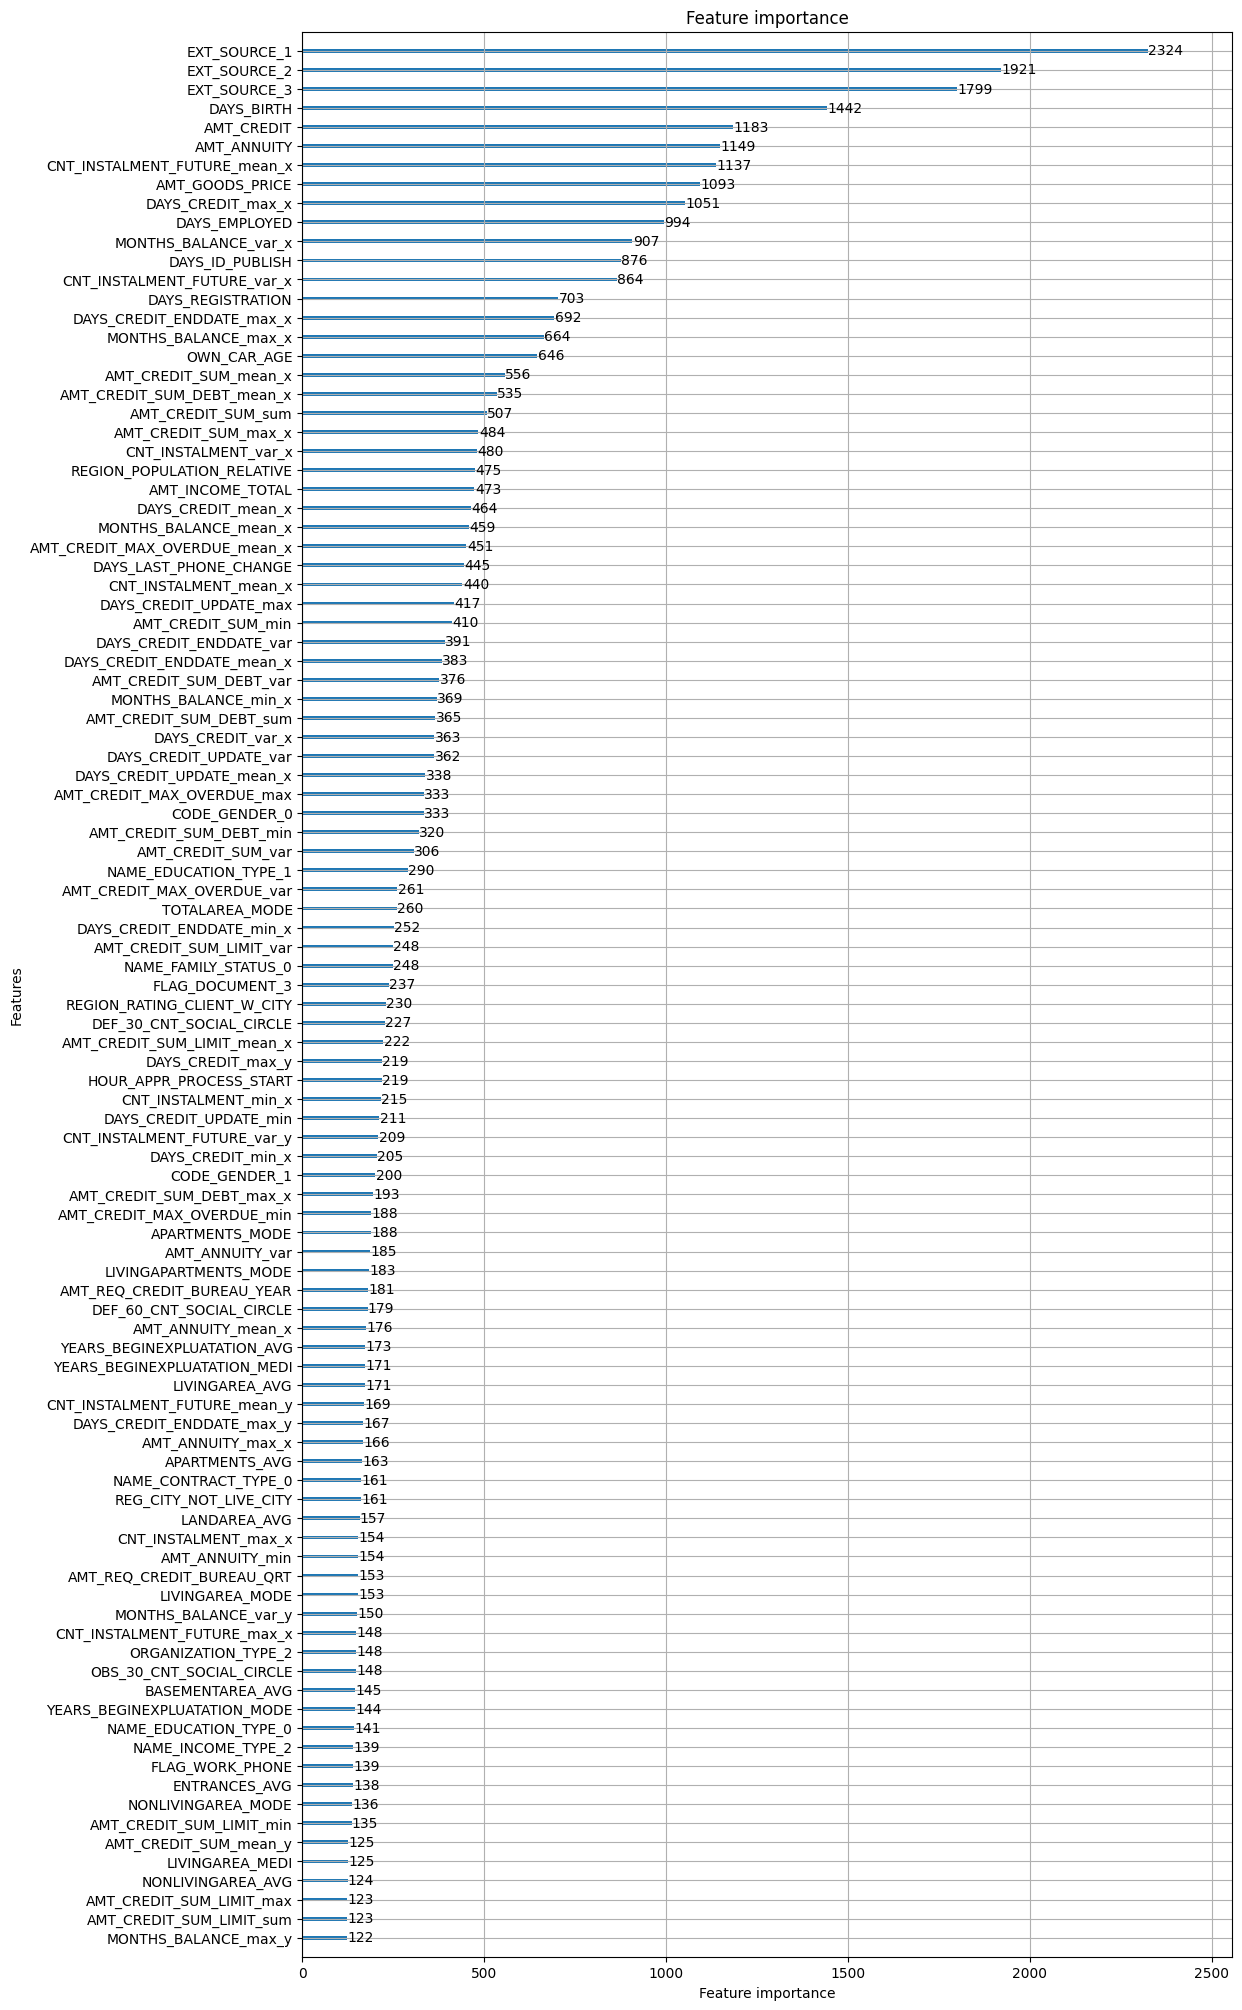

In [252]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);

In [253]:
preds = model.predict(test_X)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_model.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.040874
1,100005,0.126029
2,100013,0.018290
3,100028,0.041874
4,100038,0.185713
